# LSTM model for price prediction

## 0. Assumptions of the model

Model used : encoder decoder made of GRU cells

## 1. Packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf  
import utils
print('Imported tensorflow', tf.VERSION)

Imported tensorflow 1.8.0


## 2. Data Source

In [2]:
df = pd.read_csv('metals_daily_train.csv')
df = df.dropna(axis=0)

In [3]:
df.head()

,date,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,...,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle,week,week_date
109,20081201,444.511058,457.032497,457.032497,53.08,56.33,52.62,56.29,49.11,52.15,...,9420.0,9680.0,9315.0,9540.0,9520.0,9800.0,9495.0,9650.0,2030,20081201
110,20081202,446.908899,465.530103,459.323035,55.99,56.29,54.68,55.30,51.80,52.24,...,9480.0,9600.0,9430.0,9510.0,9640.0,9730.0,9560.0,9630.0,2030,20081201
111,20081203,453.484820,482.060575,459.696940,56.50,56.72,54.65,55.21,53.01,53.02,...,9495.0,9580.0,9400.0,9500.0,9530.0,9690.0,9505.0,9590.0,2030,20081201
112,20081204,447.532919,472.395859,459.964389,55.50,57.81,54.88,57.62,51.75,54.42,...,9485.0,9485.0,9120.0,9145.0,9400.0,9445.0,9205.0,9225.0,2030,20081201
113,20081205,447.084228,471.922241,459.503235,58.50,60.00,56.63,56.75,54.70,56.18,...,8710.0,9000.0,8595.0,8665.0,8885.0,8940.0,8670.0,8715.0,2030,20081201


In [4]:
df_p1 = df["p1"].dropna(axis=0)

## 3. Seq2Seq with GRU cells model

In [57]:
def fetch_sample(df, batch_size, input_seq_len, output_seq_len, random_state=None):
    """Get a batch from the dataframe. 
    
    Each batch contains batch_size sequences. 
    Each sequences is made of input_seq_len values and the follwing output_seq_len 
    values of the time series.
    """
    X_batch = []
    y_batch = []
    for _ in range(batch_size):
        n = df.shape[0]
        r = np.random.randint(0, n-output_seq_len-input_seq_len)
        X_batch.append(df[r:r+input_seq_len].values.reshape((-1, 1)))
        y_batch.append(df[r+input_seq_len:r+input_seq_len+output_seq_len].values.reshape((-1, 1)))
    X_batch = np.array(X_batch)
    X_batch = np.array(X_batch).transpose((1, 0, 2))
    y_batch = np.array(y_batch).transpose((1, 0, 2))
    return X_batch, y_batch

In [58]:
# Load paths to TF seq2seq model and recurrent cells to be used in this project
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn 
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell # Useful for learning long-range dependencies in sequences

# Data shape parameters
batch_size = 15 # How many time series to train on before updating model's weight parameters
output_seq_len = 6 # How many days to predict into the future
input_seq_len = 25 # How many days to train on in the past

# Internal neural network parameters
input_dim = output_dim = 1 # Univariate time series (predicting future values based on stream of historical values)
hidden_dim = 30  # Number of neurons in each recurrent unit 
num_layers = 2  # Number of stacked recurrent cells (number of recurrent layers)

# Optimizer parameters
learning_rate = 0.005  # Small lr helps not to diverge during training. 
epochs =  1000 #1000  # How many times we perform a training step (how many times we show a batch)
lr_decay = 0.9  # default: 0.9 . Simulated annealing.
momentum = 0.2  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - reduces overfitting

# Declare which airline-airport time series will be used for testing
#airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
# Exclude them from training phase
#excluded = map('-'.join, airline_airports)
# Allow fetching of same three samples during validation
random_state = 42

In [59]:
# Reset any existing graph, close any previous session, discard old variables, and start fresh
tf.reset_default_graph()
if 'sess' in globals():
    sess.close()
sess = tf.InteractiveSession()
tf.set_random_seed(random_state)

with tf.variable_scope('Seq2Seq'):
    # Input values to encoder RNN
    encoder_inputs = [tf.placeholder(tf.float32, shape=(None, input_dim), 
                     name="encoder_input_{}".format(t)) for t in range(input_seq_len)]
    
    # Target values for decoder RNN
    decoder_targets = [tf.placeholder(tf.float32, shape=(None, output_dim), 
                       name="decoder_target_{}".format(t)) for t in range(output_seq_len)]
    
    # Feed final n encoder inputs into the decoder RNN, where n = output_seq_len
    # "GO", represented by 0, starts the decoder
    decoder_inputs = [tf.zeros_like(encoder_inputs[0], dtype=np.float32, name="GO")] +\
                      encoder_inputs[-(output_seq_len - 1):]
    
    # Stack hidden recurrent layers
    cells = list()
    for i in range(num_layers):
        with tf.variable_scope('RNN_' + str(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Pass encoder and decoder inputs through model, retrieving output from the decoder at each prediction step
    decoder_outputs, decoder_state = tf.nn.seq2seq.basic_rnn_seq2seq(encoder_inputs, decoder_inputs, cell)
    
    # Squeeze decoder output into a single value, representing the forecast at that point in the sequence
    W_out = tf.Variable(tf.truncated_normal([hidden_dim, output_dim], seed=random_state)) # Output weight matrix
    b_out = tf.Variable(tf.truncated_normal([output_dim], seed=random_state)) # Output bias
    
    # Apply a trainable, constant linear transformation to final outputs
    output_scale_factor = tf.Variable(1.0, name="Output_Scale_Factor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, W_out) + b_out) for i in decoder_outputs]

In [60]:
with tf.variable_scope('Loss'):
    # Compute L2 loss for output at each time step: 
    # https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, decoder_targets):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    # Penalize model complexity with L2 regularization
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    # Add regularization term to loss function        
    loss = output_loss + lambda_l2_reg * reg_loss
    
with tf.variable_scope('Optimizer'):
    # Search for minimum of loss function with RMSProp:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum, centered=False)
    train_op = optimizer.minimize(loss)

In [61]:
def train_batch(df, batch_size, input_seq_len, output_seq_len):
    """
    Trains session model, attempting to optimize internal weight parameters
    to accurately predict the number of steps into future given by output_seq_len
    
    @df: DataFrame to sample random time series from
    @batch_size: How many time series to sample at a time
    @input_seq_len: How many months before for prediction (training)
    @output_seq_len: How many months to reserve for prediction (training target)
    """
    X_train, y_train = fetch_sample(df=df, 
                                    batch_size=batch_size, 
                                    input_seq_len=input_seq_len, 
                                    output_seq_len=output_seq_len)
    feed_dict = {encoder_inputs[t]: X_train[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_train[t] for t in range(len(decoder_targets))})
    train_loss = sess.run([train_op, loss], feed_dict)
    return train_loss

In [62]:
def test_batch(df, input_seq_len, output_seq_len, random_state=None):
    """
    Tests session model on a batch of random time series drawn from one of the metrics DataFrames.
    All passed parameters should be same as those used during training.
    
    @df: DataFrame to sample random time series from
    @batch_size: How many time series to sample at a time
    @input_seq_len: How many months before for prediction (training)
    @output_seq_len: How many months to set aside for prediction (training target)
    @random_state: Controls reproducible output
    """
    X_test, y_test = fetch_sample(df=df, 
                                  batch_size=1, 
                                  input_seq_len=input_seq_len, 
                                  output_seq_len=output_seq_len,
                                  random_state=random_state)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
    test_loss = sess.run([train_op, loss], feed_dict)
    return test_loss[1]

In [63]:
# Reset variables and run passengers training ops
sess.run(tf.global_variables_initializer())
for t in range(epochs + 1):
    train_loss = train_batch(df=df_p1, batch_size=batch_size, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
    # Taking the dev_loss on the same random samples serves as a validation run every 100 training runs
    if t % 10 == 0:
        dev_loss = test_batch(df=df_p1, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
        print("Step {0}/{1} \ttrain loss: {2} \tdev loss: {3}".format(t, epochs, train_loss[1], dev_loss))

Step 0/1000 	train loss: 10819847.0 	dev loss: 392211.65625
Step 10/1000 	train loss: 9662343.0 	dev loss: 350875.71875
Step 20/1000 	train loss: 10126165.0 	dev loss: 913758.25
Step 30/1000 	train loss: 8606787.0 	dev loss: 709574.875
Step 40/1000 	train loss: 10627357.0 	dev loss: 293439.1875
Step 50/1000 	train loss: 9428605.0 	dev loss: 413006.96875
Step 60/1000 	train loss: 8060102.5 	dev loss: 427937.46875
Step 70/1000 	train loss: 9481728.0 	dev loss: 197784.609375
Step 80/1000 	train loss: 7847341.0 	dev loss: 604741.4375
Step 90/1000 	train loss: 8250204.0 	dev loss: 404617.375
Step 100/1000 	train loss: 9400995.0 	dev loss: 569758.25
Step 110/1000 	train loss: 7606292.5 	dev loss: 776747.5625
Step 120/1000 	train loss: 8650230.0 	dev loss: 797670.3125
Step 130/1000 	train loss: 8409444.0 	dev loss: 673360.8125
Step 140/1000 	train loss: 7653629.0 	dev loss: 365980.8125
Step 150/1000 	train loss: 7712994.5 	dev loss: 502598.15625
Step 160/1000 	train loss: 6478265.0 	dev loss:

## 4. Example

In [64]:
X_test, y_test = fetch_sample(df_p1, 1, input_seq_len, output_seq_len, random_state=random_state)
feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
res = sess.run([reshaped_outputs], feed_dict=feed_dict)[0]
res

[array([[ 534.925354]], dtype=float32),
 array([[ 534.95220947]], dtype=float32),
 array([[ 534.97644043]], dtype=float32),
 array([[ 535.]], dtype=float32),
 array([[ 535.02288818]], dtype=float32),
 array([[ 535.04522705]], dtype=float32)]

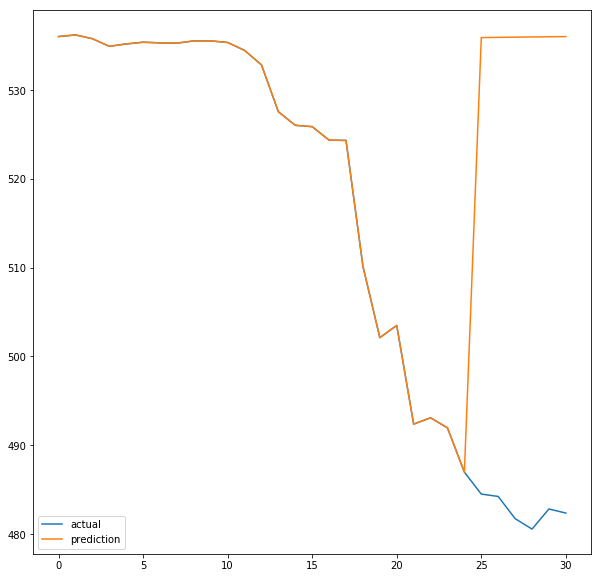

In [65]:
def viz_prediction(X_test, y_test, batch_sample_nb):
    assert (batch_sample_nb < batch_size) & (batch_sample_nb > 0)
    X_test, y_test = fetch_sample(df_p1, batch_size, input_seq_len, output_seq_len)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
    res = sess.run([reshaped_outputs], feed_dict=feed_dict)[0]
    res = np.array(res)
    # shape: (output_seq_len, batch_size, input_dim)
    res.transpose((1,0,2))
    X_plot = list(X_test[:, batch_sample_nb, :].flatten())
    y_plot = list(y_test[:, batch_sample_nb, :].flatten())
    y_pred = list(res[:, batch_sample_nb].flatten())
    plt.figure(figsize=(10,10))
    plt.plot(X_plot + y_plot, label='actual')
    plt.plot(X_plot + y_pred, label='prediction')
    plt.legend()
    plt.show()
    
viz_prediction(X_test, y_test, 1)